# Solving Linear Inverse Problems Using the Prior Implicit in a Denoiser : Experiments

Part of the code comes from [universal_inverse_problem](https://github.com/LabForComputationalVision/universal_inverse_problem) and [bias_free_denoising](https://github.com/LabForComputationalVision/bias_free_denoising).

In [13]:
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import os
import time
import torch
import sys
# sys.path.insert(0, 'code')
from Utils_inverse_prob import *
from network import BF_CNN
from algorithm_inv_prob import *
#from denoisers2 import CVDenoiser

%matplotlib inline

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import random


import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import argparse

from tqdm import tqdm



## Define Model

In [15]:

def def_args(grayscale=False, num_kernels = 64):
    '''
    Needed to initialize a BF_CNN model
    @ grayscale: if True, number of input and output channels are set to 1. Otherwise 3
    '''
    parser = argparse.ArgumentParser(description='BF_CNN_color')
    parser.add_argument('--dir_name', default= '../noise_range_')
    parser.add_argument('--kernel_size', default= 3)
    parser.add_argument('--padding', default= 1)
    parser.add_argument('--num_kernels', default= num_kernels)
    parser.add_argument('--num_layers', default= 20)
    if grayscale is True:
        parser.add_argument('--num_channels', default= 1)
    else:
        parser.add_argument('--num_channels', default= 3)

    args = parser.parse_args('')
    return args



## Define Datasets

In [16]:

class RandomCropMNISTDataset(Dataset):
    """
    Noisy MNIST Dataset
    """
    def __init__(self, root, transform=None, crop_size=24, num_crops=1, max_std=0.1, train=True):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, transform=None, download=True)
        self.transform = transform
        self.crop_size = crop_size
        self.num_crops = num_crops
        self.max_std = max_std

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        image, label = self.mnist_dataset[index]

        # Perform random crops
        crops = []
        for _ in range(self.num_crops):
            x = random.randint(0, image.size[0] - self.crop_size)
            y = random.randint(0, image.size[1] - self.crop_size)
            cropped_image = image.crop((x, y, x + self.crop_size, y + self.crop_size))

            # Apply transformations
            if self.transform is not None:
                cropped_image = self.transform(cropped_image)

            # Add Gaussian noise to the cropped image
            std_dev = random.uniform(0, self.max_std)
            noised_image = self.add_gaussian_noise(cropped_image, std_dev)

            crops.append((cropped_image, noised_image, label))

        return crops

    def add_gaussian_noise(self, image, std_dev):
        noise = torch.randn_like(image) * std_dev
        noised_image = image + noise
        return noised_image



In [17]:
class RandomCropCustomDataset(Dataset):
    """
    Noisy Custom Dataset
    """
    def __init__(self, root, transform=None, crop_size=24, num_crops=1, max_std=0.1):
        self.root = root
        self.transform = transform
        self.crop_size = crop_size
        self.num_crops = num_crops
        self.max_std = max_std

        # Get the list of image files in the specified folder
        self.image_files = [f for f in os.listdir(root) if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # Load the image
        image_path = os.path.join(self.root, self.image_files[index])
        image = Image.open(image_path).convert('RGB')

        # Perform random crops
        crops = []
        for _ in range(self.num_crops):
            x = random.randint(0, image.size[0] - self.crop_size)
            y = random.randint(0, image.size[1] - self.crop_size)
            cropped_image = image.crop((x, y, x + self.crop_size, y + self.crop_size))

            # Apply transformations
            if self.transform is not None:
                cropped_image = self.transform(cropped_image)

            # Add Gaussian noise to the cropped image
            std_dev = random.uniform(0, self.max_std)
            noised_image = self.add_gaussian_noise(cropped_image, std_dev)

            crops.append((cropped_image, noised_image))

        return crops

    def add_gaussian_noise(self, image, std_dev):
        noise = torch.randn_like(image) * std_dev
        noised_image = image + noise
        return noised_image

# # Example usage:
# # Define the transform to normalize and convert to PyTorch tensor
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# # Create the dataset
# custom_dataset = RandomCropCustomDataset(root='test_images\color\BSD100', transform=transform, crop_size=24, num_crops=5, max_std=0.1)

# # Access a sample from the dataset
# sample = custom_dataset[0]


## Training

In [18]:
%%script false --no-raise-error # Remove this line to train
# Define the Mean Squared Error (MSE) loss
criterion = nn.MSELoss()

# Instantiate the model, optimizer, and dataset
args = def_args(grayscale=True)
model = BF_CNN(args)
optimizer = optim.Adam(model.parameters(), lr=0.001)


transform = transforms.Compose([
    transforms.ToTensor(),
])

crop_size = 28

mnist_dataset = RandomCropMNISTDataset(root="test_images/grayscale/mnist", transform=transform, crop_size=crop_size, num_crops=1, max_std=0.4, train=True)

# DataLoader for batching and shuffling
dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_clean, batch_noised, _ = batch[0]
        batch_clean, batch_noised = batch_clean.to(device), batch_noised.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_noised)

        # Compute the MSE loss
        loss = criterion(outputs, batch_clean)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

print("Training complete.")

torch.save(model.state_dict(), f'bf_cnn_mnist_trained_with_crops_{crop_size}x{crop_size}_{num_epochs}.pth')



Couldn't find program: 'false'


In [19]:
%%script false --no-raise-error # Remove this line to train
# Define the Mean Squared Error (MSE) loss
criterion = nn.MSELoss()

# Instantiate the model, optimizer, and dataset
args = def_args(grayscale=False)
model = BF_CNN(args)
optimizer = optim.Adam(model.parameters(), lr=0.001)
#
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
])

crop_size = 40

custom_dataset = RandomCropCustomDataset(root="test_images/color/BSD100", transform=transform, crop_size=crop_size, num_crops=4, max_std=0.4)

# DataLoader for batching and shuffling
dataloader = DataLoader(custom_dataset, batch_size=16, shuffle=True)

# Training loop
num_epochs = 2_000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):

        batch_clean, batch_noised = zip(*batch)  # Unpack the list of tuples
        batch_clean = torch.cat(batch_clean).to(device)
        batch_noised = torch.cat(batch_noised).to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_noised)

        # Compute the MSE loss
        loss = criterion(outputs, batch_clean)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
    if  (epoch+1) % 100 == 0:
      torch.save(model.state_dict(), f'bf_cnn_trained_with_crops3_{crop_size}x{crop_size}_{epoch+1}.pth')

print("Training complete.")

Couldn't find program: 'false'


## Tests/ Synthesis

In [20]:
def plot_side_by_side(arrays, greyscale = False):
    """
    Display multiple 2D arrays side by side in a single plot.

    Parameters:
    - arrays (list of numpy arrays): List of 2D arrays to be displayed.

    Usage:
    >>> arrays = [array1, array2, array3]
    >>> plot_side_by_side(arrays)
    """

    # Determine the number of arrays
    num_arrays = len(arrays)

    # Create subplots with a single row and 'num_arrays' columns
    fig, axes = plt.subplots(1, num_arrays, figsize=(15, 5))

    # Set the colormap to 'viridis' for 2D arrays, and 'grey' for 1D arrays
    cmap = 'viridis' if not greyscale else 'Greys' # "grey"

    # Display each array in a separate subplot
    for i in range(num_arrays):
        axes[i].imshow(arrays[i], cmap=cmap)
        axes[i].axis('off')

    # Show the plot
    plt.show()


In [21]:
def simple_synthesis(denoiser, greyscale, shape = (28,28), h=0.1, gamma = 0., iter = 25, sigma_0 = 1.):
    """
    Hand-made gradient ascent. More stable.
    """

    if greyscale:
        C = 1
    else:
        C = 3 

    y = torch.randn((1,C,*shape)) * sigma_0 + .5
    imgs = [y.clone().transpose(-3,-2).transpose(-2,-1).squeeze().detach().numpy()]
    for i in range(iter):
        y += h*(denoiser(y) - y)   +  (gamma *torch.randn_like(y) ) / (i+1)

        if i % 5 == 0:
            imgs.append(y.clone().transpose(-3,-2).transpose(-2,-1).squeeze().detach().numpy())
        # plt.imshow(y.squeeze().detach().numpy())
        # plt.show()
    plot_side_by_side(imgs, greyscale=greyscale)

In [22]:
def simple_synthesis_np(denoiser, shape = (28,28), h=0.1, gamma = 0., iter = 25, sigma_0 = 1.):
    """
    Numpy version
    """
    y = sigma_0 * np.random.randn(*shape,3) + .5
    imgs = [y.copy()]
    for i in range(iter):
        y +=  h*( denoiser(y) - y)   +  ( gamma * np.random.randn(*shape,3) )
        if i % 5 == 0:
            imgs.append(y.copy())

    plot_side_by_side(imgs)

## Tests

In [23]:
trained_bfcnn = './trained_bf_cnn/'

# Datasets available in the data folder
mnist_trained_path = os.path.join(trained_bfcnn,'mnist/')
bsd_trained_path = os.path.join(trained_bfcnn,  'bsd/')



### BF-CNN MNIST synthesis

In [24]:
args = def_args(grayscale=True,num_kernels=64)

print("Choose checkpoint")
print(os.listdir(mnist_trained_path))

checkpoint_mnist = "bf_cnn_mnist_trained_with_crops_24x24.pth"
# Initialize the model
bf_cnn_mnist = BF_CNN(args)
bf_cnn_mnist.load_state_dict(torch.load( os.path.join(mnist_trained_path, checkpoint_mnist) ,map_location=torch.device('cpu')))
bf_cnn_mnist.eval();

Choose checkpoint
['bf_cnn_mnist_trained_with_crops_24x24.pth']


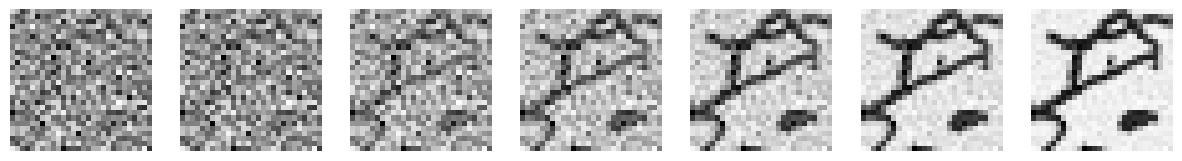

In [25]:
simple_synthesis(bf_cnn_mnist,greyscale=True, iter = 30)

### BF-CNN BSD synthesis

In [71]:
args = def_args(grayscale=False,num_kernels=64)

print("Choose checkpoint")
print(os.listdir(bsd_trained_path))

checkpoint_bsd = 'bf_cnn_trained_with_crops3_40x40_1000.pth'
# Initialize the model
bf_cnn_bsd = BF_CNN(args)
bf_cnn_bsd.load_state_dict(torch.load(os.path.join(bsd_trained_path, checkpoint_bsd),map_location=torch.device('cpu')))
bf_cnn_bsd.eval();

Choose checkpoint
['bf_cnn_trained_with_crops2_50x50_1000.pth', 'bf_cnn_trained_with_crops2_50x50_1950.pth', 'bf_cnn_trained_with_crops2_50x50_300.pth', 'bf_cnn_trained_with_crops2_50x50_50.pth', 'bf_cnn_trained_with_crops3_40x40_1000.pth', 'bf_cnn_trained_with_crops3_40x40_1900.pth', 'bf_cnn_trained_with_crops3_40x40_300.pth', 'bf_cnn_trained_with_crops3_40x40_900.pth', 'bf_cnn_trained_with_crops_60x60_1896.pth', 'bf_cnn_trained_with_crops_60x60_768.pth']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


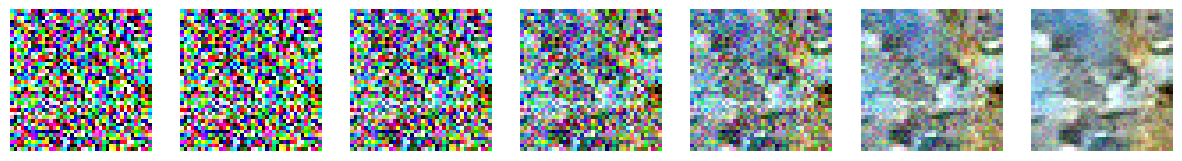

In [79]:
simple_synthesis(bf_cnn_bsd,False, shape= (40,40),iter= 30, gamma=.1)

### Total Variation synthesis

In [28]:
from skimage.restoration import denoise_tv_chambolle

def get_tv_denoiser(weight = 0.1):
    def denoiser(x):
        return denoise_tv_chambolle(x,weight)
    return denoiser

weight = 0.1
tv_denoiser = get_tv_denoiser(weight)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


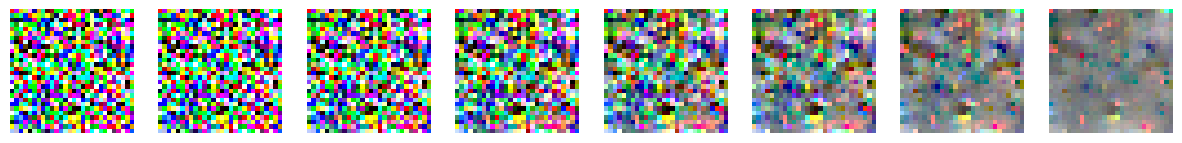

In [29]:
simple_synthesis_np(tv_denoiser,h = 0.2,gamma= 0.01,iter=35)

### Does not work

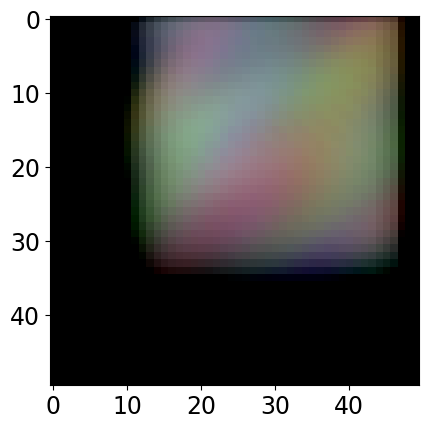

In [30]:
from skimage.restoration import denoise_bilateral
y = np.random.randn(50,50,3) + .5
for i in range(30):
    y += 0.2*( denoise_bilateral(y,channel_axis=-1) - y)   # +  (0.01 * np.random.randn(28,28,3) )
    plt.imshow(np.clip(y.squeeze(),0,1),cmap='Greys')
plt.show()

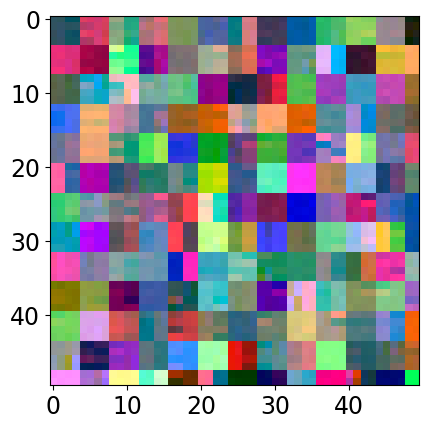

In [31]:
from skimage.restoration import denoise_wavelet
y = np.random.randn(50,50,3) + .5

for i in range(20):
    y += .2*( denoise_wavelet(y,channel_axis=-1,mode='soft') - y)   # +  (0.01 * np.random.randn(28,28,3) )
    plt.imshow(np.clip(y.squeeze(),0,1),cmap='Greys')
plt.show()

In [32]:
import deepinv as dinv
gsdrunet = dinv.models.GSDRUNet(pretrained="download", train=False)

In [33]:
def get_gsdrun(model,sigma):
    def mod(x):
        return model(x,sigma)
    
    return mod

In [34]:
gsdrun = get_gsdrun(gsdrunet,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


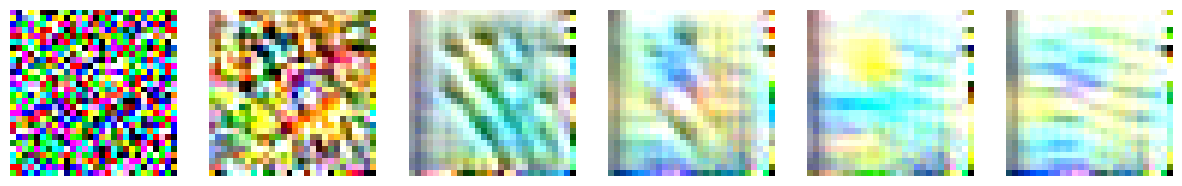

In [35]:
simple_synthesis(gsdrun,False,h=1)

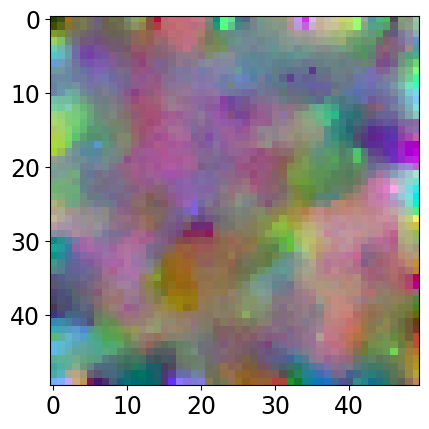

In [36]:
from skimage.restoration import denoise_tv_bregman
y = np.random.randn(50,50,3) + .5

for i in range(20):
    y += 0.3*( denoise_tv_bregman(y,channel_axis=-1) - y)  +  (0.01 * np.random.randn(50,50,3) )
    plt.imshow(np.clip(y.squeeze(),0,1),cmap='Greys')
plt.show()

## Bias VS No-Bias

The models for this part comes from https://github.com/LabForComputationalVision/bias_free_denoising

In [37]:
from utils import *
%matplotlib inline

In [38]:
# Paths for data, pretrained models, and precomputed performance measures
pretrained_base = './pretrained/'
precomputed_base = './precomputed/'
data_base = 'data/'

# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/') 




### Choose a model 

Note: we provide four pre-trained models. You can train and analyze any other model (and its bias-free counterpart) using the train script provided in the repository. 


In [39]:

# Choose a model (pre-trained options: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn' 

# Select the range of noise levels (stdev, relative to intensities in range [0,255]) 
# used during training (options are 0-10, 0-30, 0-55, 0-100).
l = 0   # lower bound of training range 
h = 100 # upper bound of training range

bf_cnn= load_model(os.path.join(pretrained_base, model, 'bias_free', str(l)+'-'+str(h)+'.pt'))
bf_cnn.eval();

b_cnn= load_model(os.path.join(pretrained_base, model, 'bias', str(l)+'-'+str(h)+'.pt'))
b_cnn.eval();


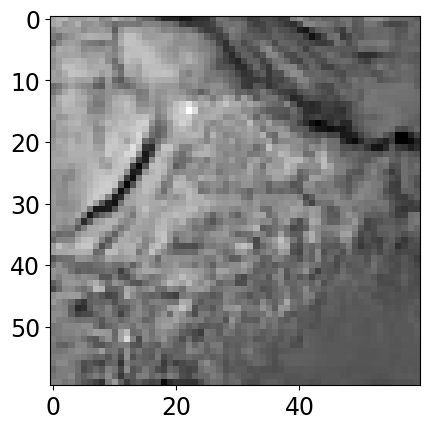

In [40]:

y = (torch.randn((1,1,60,60))+0.5)
for _ in range(25):
    y += 0.3*(bf_cnn(y) - y)
    plt.imshow(y.squeeze().detach().numpy(),cmap='gray')
plt.show()


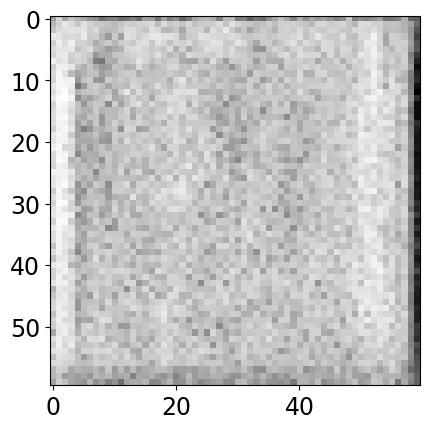

In [41]:

y = (torch.randn((1,1,60,60))+0.5)*255
for _ in range(20):
    y += 0.5*(b_cnn(y) - y)
    plt.imshow(y.squeeze().detach().numpy(),cmap='Greys')
plt.show()


In [42]:
model = 'rcnn'
b_rcnn= load_model(os.path.join(pretrained_base, model, 'bias', str(l)+'-'+str(h)+'.pt'))
b_rcnn.eval();
bf_rcnn= load_model(os.path.join(pretrained_base, model, 'bias_free', str(l)+'-'+str(h)+'.pt'))
bf_rcnn.eval();

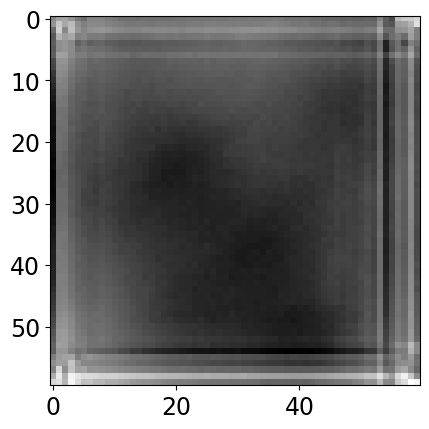

In [43]:


y = (torch.randn((1,1,60,60))+0.5)*255
for _ in range(20):
    y += 0.5*(b_rcnn(y) - y)
    plt.imshow(y.squeeze().detach().numpy(),cmap='Greys')
plt.show()


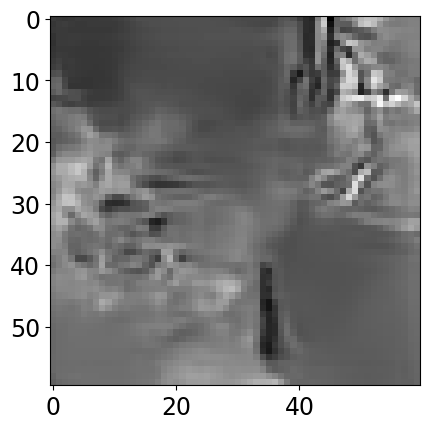

In [44]:

y = (torch.randn((1,1,60,60))+0.5)*255
for _ in range(20):
    y += 0.5*(bf_rcnn(y) - y)
    plt.imshow(y.squeeze().detach().numpy(),cmap='Greys')
plt.show()


In [45]:

model = 'unet'
b_unet= load_model(os.path.join(pretrained_base, model, 'bias', str(l)+'-'+str(h)+'.pt'))
b_unet.eval();
bf_unet= load_model(os.path.join(pretrained_base, model, 'bias_free', str(l)+'-'+str(h)+'.pt'))
bf_unet.eval();


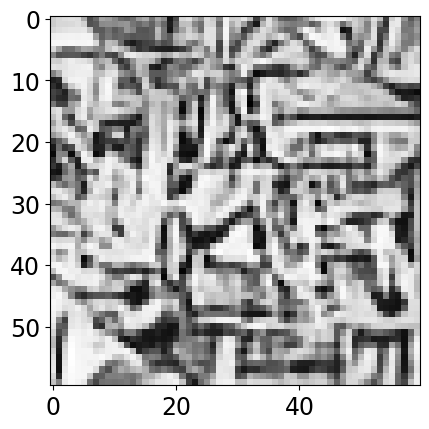

In [46]:
y = (torch.randn((1,1,60,60))+0.5)
for _ in range(20):
    y += 0.5*(b_unet(y) - y)
    plt.imshow(y.squeeze().detach().numpy(),cmap='Greys')
plt.show()


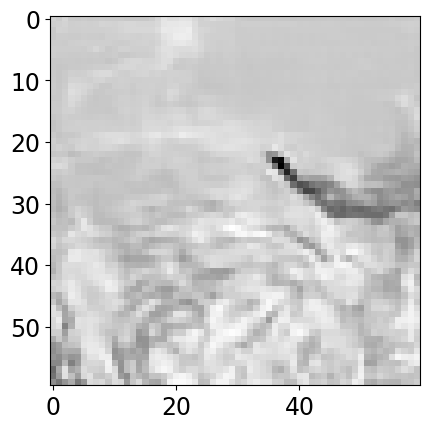

In [47]:
y = (torch.randn((1,1,60,60))+0.5)
for _ in range(25):
    y += 0.5*(bf_unet(y) - y)
    plt.imshow(y.squeeze().detach().numpy(),cmap='Greys')
plt.show()